In [1]:
!pip install kaggle

In [2]:
from google.colab import files

# Upload your Kaggle API key file (kaggle.json)
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
import os

# Move the uploaded Kaggle API key to the correct location
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

In [4]:
dataset_name = 'abdallahwagih/kvasir-dataset-for-classification-and-segmentation/'

# Download the dataset
!kaggle datasets download -d {dataset_name}

kvasir-dataset-for-classification-and-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
dataset_name = 'kvasir-dataset-for-classification-and-segmentation'

In [6]:
!unzip -q {dataset_name}.zip -d {dataset_name}

replace kvasir-dataset-for-classification-and-segmentation/kvasir-dataset/kvasir-dataset/dyed-lifted-polyps/0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
All
[A]


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Concatenate, Flatten, Conv2D, AveragePooling2D, MaxPool2D, Reshape, Conv2DTranspose

import os

from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.morphology import label
from PIL import Image

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Reshape
from tensorflow.keras.initializers import glorot_uniform

In [8]:
mainPath = "/content/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG"
imagesPath = mainPath + "/images"
masksPath = mainPath + "/masks"

In [9]:
print(f"Total images: {len(os.listdir(imagesPath))}\nTotal masks: {len(os.listdir(masksPath))}")

Total images: 1000
Total masks: 1000


In [10]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [11]:
# creating image ids i.e the file name eg: cju0qoxqj9q6s0835b43399p4.jpg
images_ids = next(os.walk(imagesPath))[2]
masks_ids = next(os.walk(masksPath))[2]

In [12]:
# Creating blank array of the length og image_ids i.e 1000
X = np.zeros((len(images_ids), 256, 256, 3), dtype=np.uint8)
Y = np.zeros((len(masks_ids), 256, 256, 1), dtype=np.bool_)

In [13]:
# Resizing the images to 256, 256 and then afdding them to the above matrix
print("Resizing training images and masks")
for n, id_ in tqdm(enumerate(images_ids), total=len(images_ids)):
    path = imagesPath + "/" + id_
    img = imread(path)[:, :, :3]
    img = resize(img, (256, 256), mode="constant", preserve_range=True)
    X[n] = img
    mask = np.zeros((256, 256, 1), dtype=np.bool_)
    mask = imread(masksPath + "/" + id_)
    mask = rtg(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    Y[n] = mask

Resizing training images and masks


100%|██████████| 1000/1000 [00:54<00:00, 18.43it/s]


In [14]:
# Shape of the final matrix
print(f"X_train.shape: {X.shape}\nY_train.shape: {Y.shape}")

X_train.shape: (1000, 256, 256, 3)
Y_train.shape: (1000, 256, 256, 1)


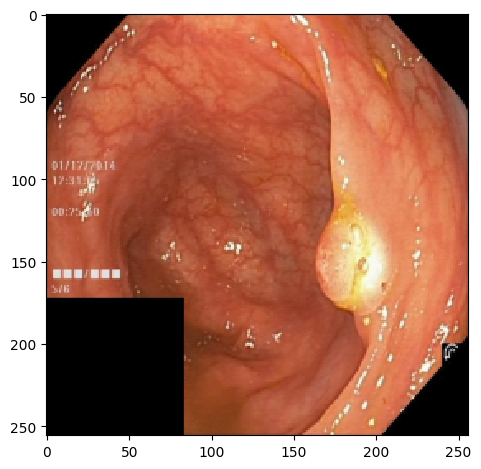

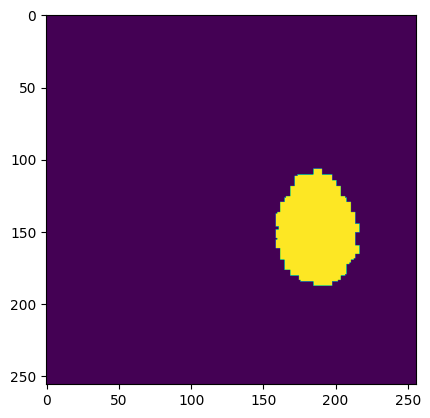

In [15]:
# Plotting random images and their mask
import random
image_x = random.randint(0, len(images_ids))
imshow(X[image_x])
plt.show()
plt.imshow(np.squeeze(Y[image_x]))

In [16]:
# Creating training and validation data
x_train = X[:800]
y_train = Y[:800]
x_val = X[800:900]
y_val = Y[800:900]
x_test = X[900:]
y_test = Y[900:]

In [17]:
# The custom U-Net Architecture

# Input image
input = tf.keras.layers.Input((256, 256, 3))

# reduce image config
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

modelUNet = tf.keras.Model(inputs=input, outputs=outputs, name='U-NET')

modelUNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
callbacks=[tf.keras.callbacks.TensorBoard(log_dir="logs")]


results = modelUNet.fit(x_train, y_train, validation_data = (x_val,y_val), batch_size=8, epochs=70, callbacks=callbacks)

Epoch 1/70
100/100 [==============================] - 38s 168ms/step - loss: 0.5308 - accuracy: 0.8125 - val_loss: 0.3898 - val_accuracy: 0.8502
Epoch 2/70
100/100 [==============================] - 15s 153ms/step - loss: 0.4102 - accuracy: 0.8253 - val_loss: 0.3614 - val_accuracy: 0.8502
Epoch 3/70
100/100 [==============================] - 16s 157ms/step - loss: 0.4082 - accuracy: 0.8253 - val_loss: 0.3949 - val_accuracy: 0.8502
Epoch 4/70
100/100 [==============================] - 16s 155ms/step - loss: 0.3938 - accuracy: 0.8253 - val_loss: 0.3788 - val_accuracy: 0.8502
Epoch 5/70
100/100 [==============================] - 16s 156ms/step - loss: 0.3814 - accuracy: 0.8253 - val_loss: 0.3514 - val_accuracy: 0.8502
Epoch 6/70
100/100 [==============================] - 15s 152ms/step - loss: 0.3715 - accuracy: 0.8257 - val_loss: 0.3459 - val_accuracy: 0.8505
Epoch 7/70
100/100 [==============================] - 15s 152ms/step - loss: 0.3667 - accuracy: 0.8328 - val_loss: 0.3910 - val_ac

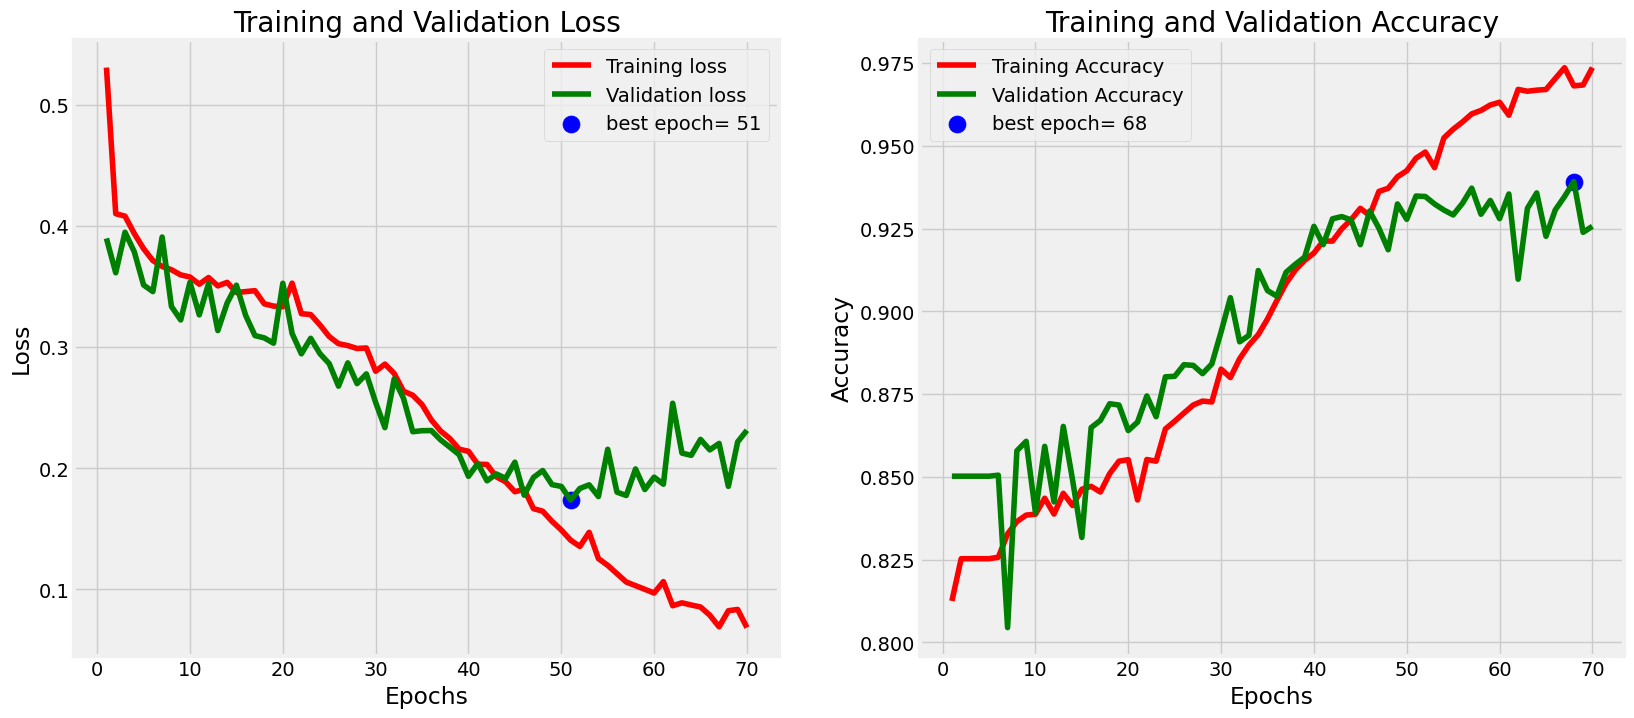

In [19]:
plot_training(results)

In [20]:
modelUNet.evaluate(X, Y)

32/32 [==============================] - 8s 93ms/step - loss: 0.0927 - accuracy: 0.9677


[0.09274806827306747, 0.9676756858825684]

In [21]:
modelUNet.evaluate(x_train, y_train)

25/25 [==============================] - 2s 96ms/step - loss: 0.0532 - accuracy: 0.9790


[0.05319845676422119, 0.9790189266204834]

In [22]:
modelUNet.evaluate(x_val, y_val)

4/4 [==============================] - 0s 71ms/step - loss: 0.2314 - accuracy: 0.9257


[0.23140834271907806, 0.9256945848464966]

In [23]:
modelUNet.evaluate(x_test, y_test)

4/4 [==============================] - 0s 72ms/step - loss: 0.2705 - accuracy: 0.9189


[0.2704847753047943, 0.9189100861549377]

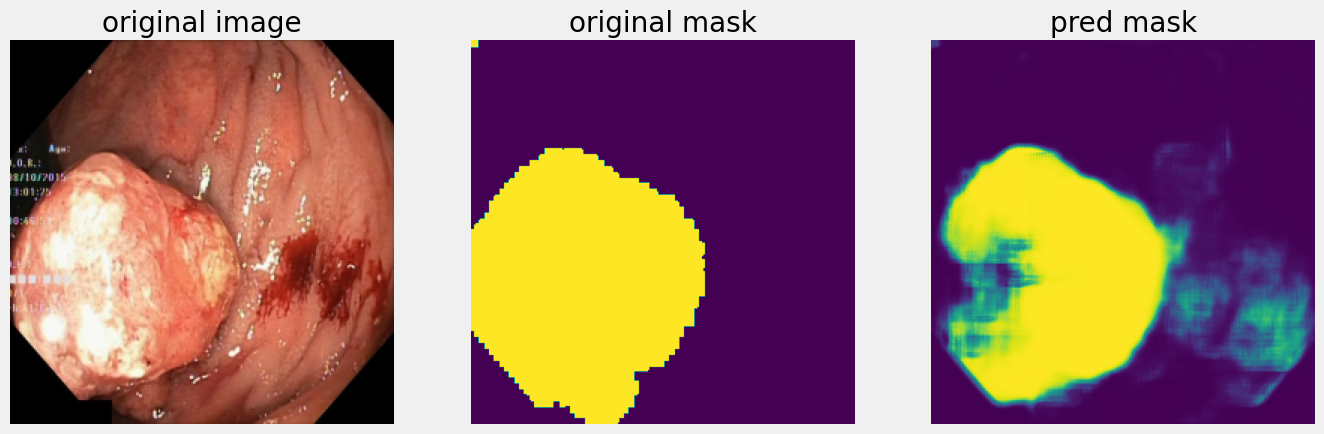

In [24]:
ind = random.randint(0, len(x_val))
img = x_val[ind]
predMask = modelUNet.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("original image")
ax1.axis('off')
ax1.imshow(x_val[ind])
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("original mask")
ax2.axis('off')
ax2.imshow(np.squeeze(y_val[ind]))
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pred mask")
ax3.axis('off')
ax3.imshow(np.squeeze(predMask))

In [25]:
from tensorflow.keras import backend as K

In [26]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [27]:
subject = 'Kvasir Segmentation'
save_path = './'


save_id = str(f'{subject} model.h5')
model_save_loc = os.path.join(save_path, save_id)
modelUNet.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as ./Kvasir Segmentation model.h5


In [28]:
modelUNet.save_weights("unet_model_weights.h5")

In [29]:
# img_path = ""
# img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
# input_array = tf.keras.preprocessing.image.img_to_array(img)
# input_array = np.array([input_array])  # Convert single image to a batch.
predictions = modelUNet.predict(x_val)
predictions

4/4 [==============================] - 0s 89ms/step


array([[[[2.0997858e-01],
         [1.6914833e-01],
         [1.6685112e-01],
         ...,
         [2.3492263e-03],
         [2.8721455e-03],
         [2.0827448e-03]],

        [[1.5147085e-01],
         [1.9214164e-01],
         [1.9356437e-01],
         ...,
         [8.8404980e-04],
         [4.2711769e-04],
         [9.9175995e-05]],

        [[1.6826415e-01],
         [1.6087189e-01],
         [1.8286662e-01],
         ...,
         [7.2148570e-04],
         [1.7294564e-04],
         [4.0960542e-05]],

        ...,

        [[1.0738287e-02],
         [3.8212694e-03],
         [2.1385399e-03],
         ...,
         [2.1810501e-03],
         [8.7430526e-04],
         [2.0727544e-04]],

        [[1.9250192e-02],
         [3.1867765e-03],
         [8.4725244e-04],
         ...,
         [5.8057543e-04],
         [2.6723708e-04],
         [2.5557744e-04]],

        [[4.3224648e-02],
         [5.7322844e-03],
         [7.3998678e-04],
         ...,
         [2.0200247e-04],
        

In [30]:
threshold = 0.5
predicted_masks = predictions > threshold

In [31]:
predicted_masks

array([[[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        ...,

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]],


       [[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [Fa

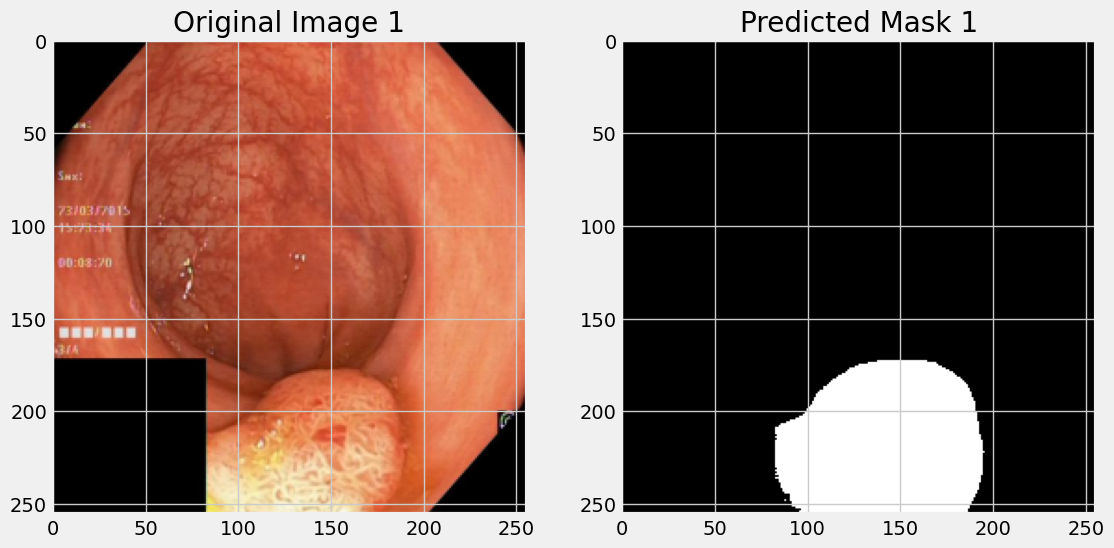

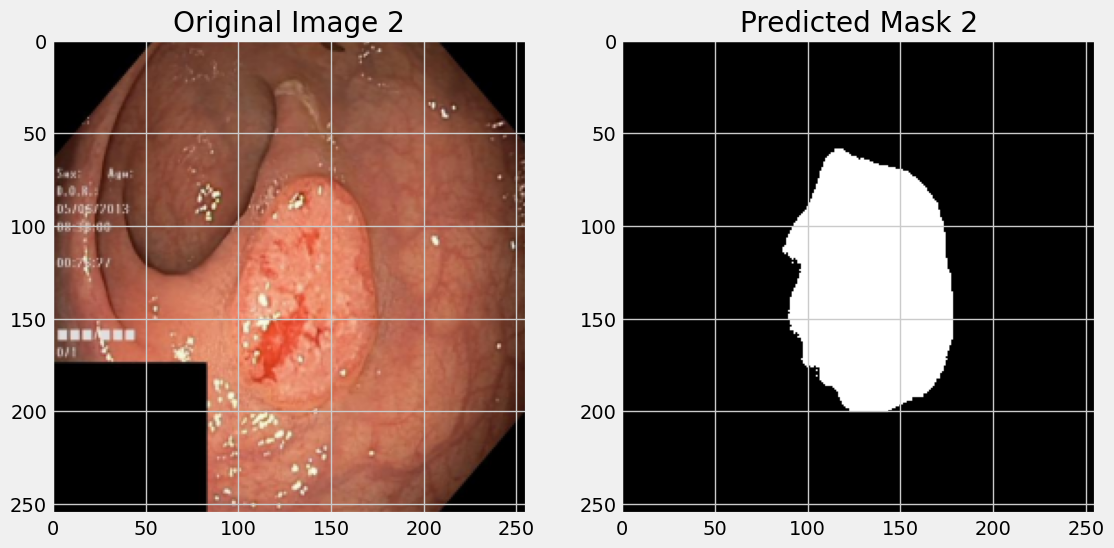

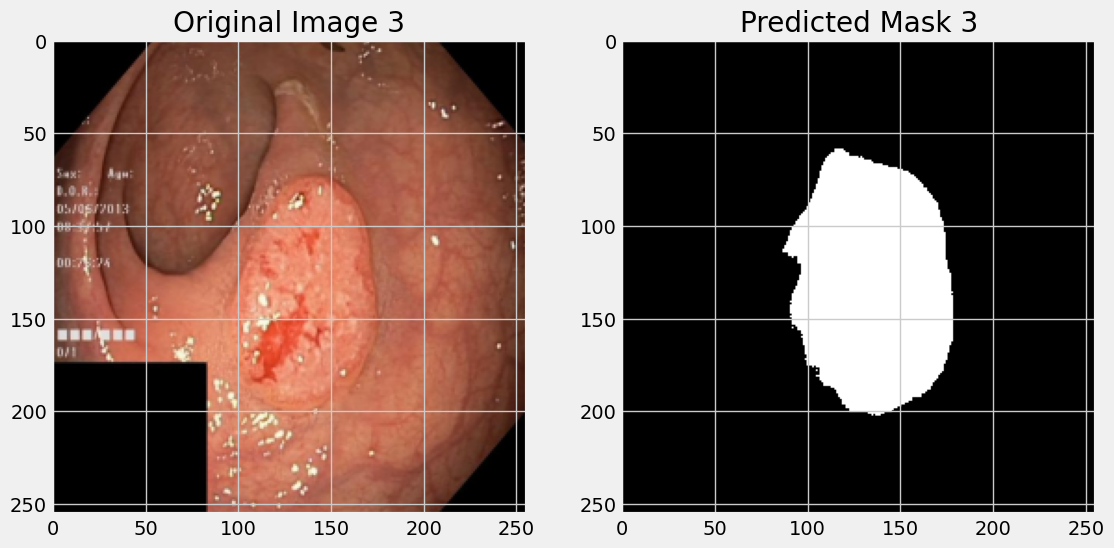

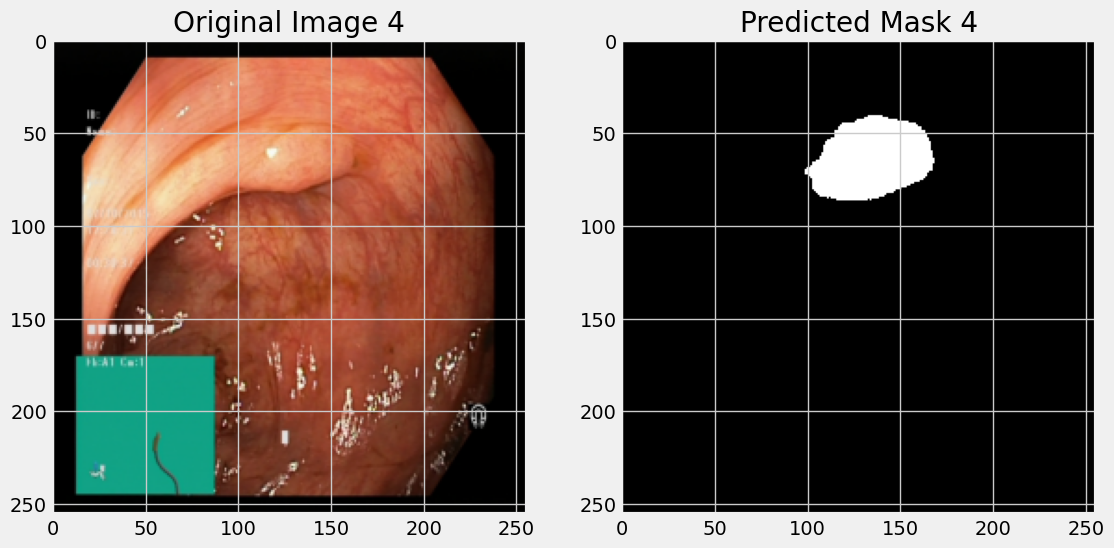

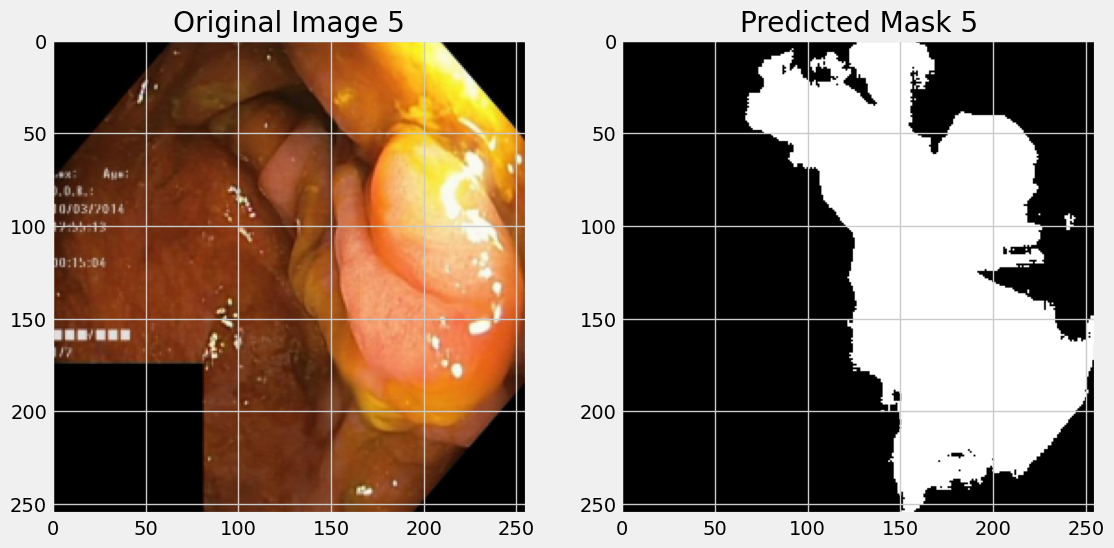

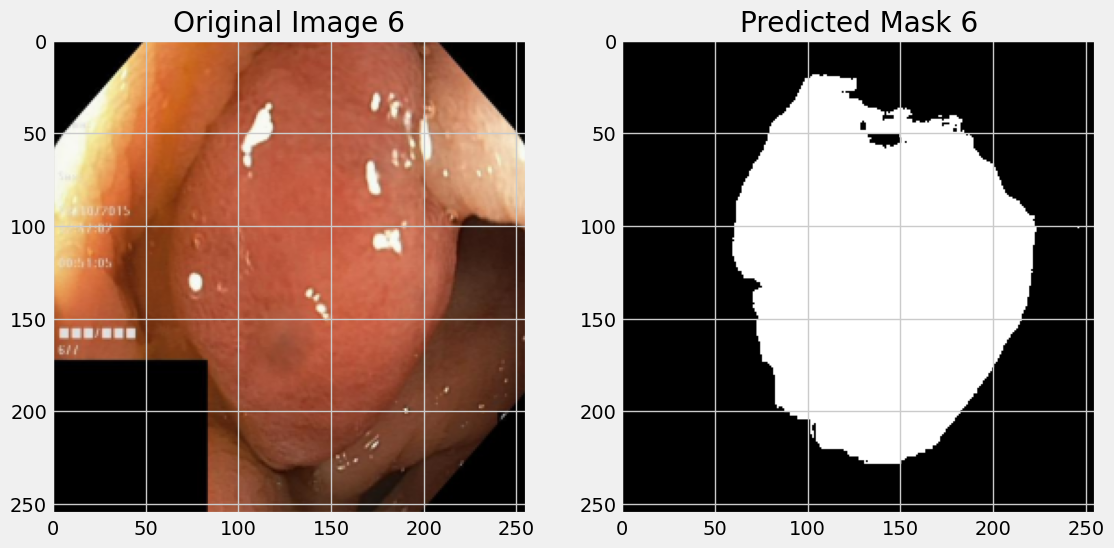

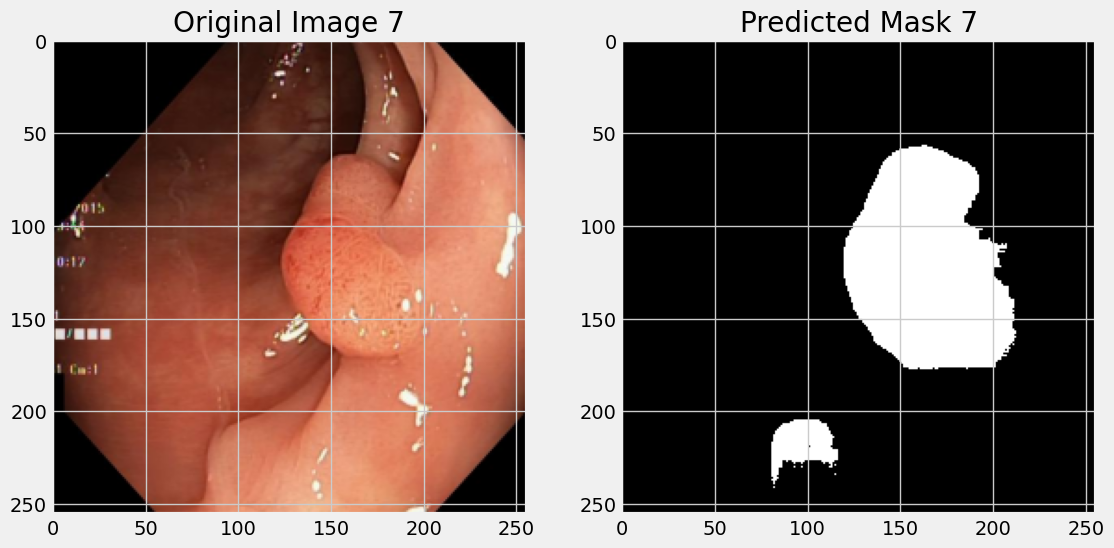

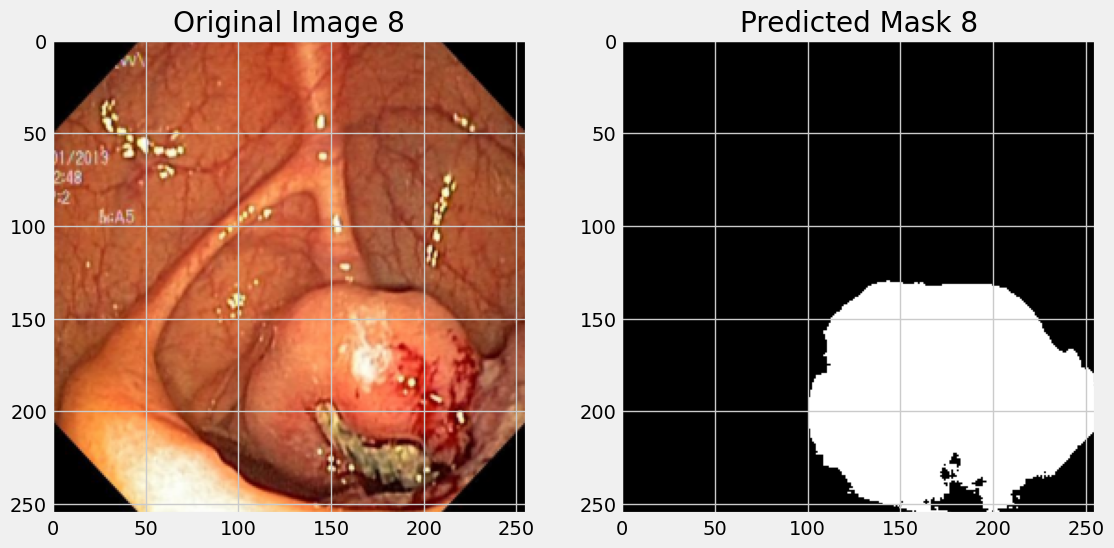

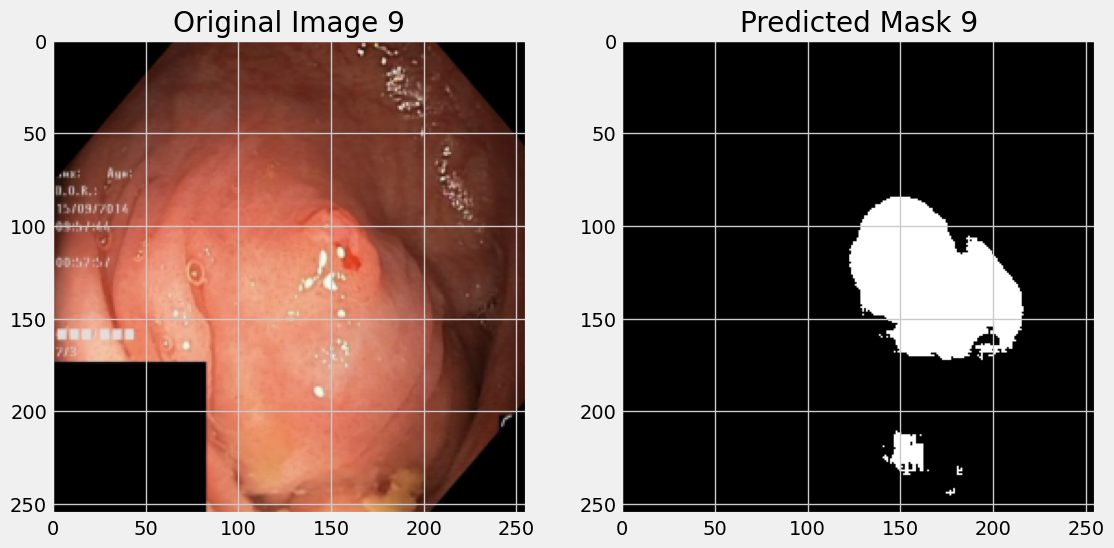

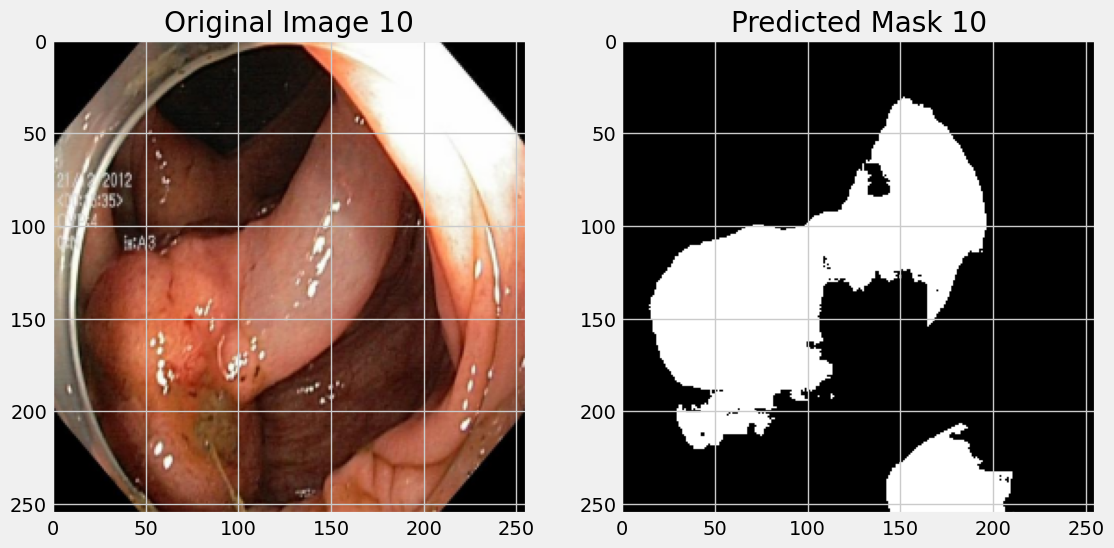

In [32]:
for i in range(10):
    # Display the original image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(x_val[i])
    plt.title(f'Original Image {i + 1}')

    # Display the predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_masks[i, :, :, 0], cmap='gray')  # Assuming a binary mask
    plt.title(f'Predicted Mask {i + 1}')

    plt.show()